<a href="https://colab.research.google.com/github/akanupam/PyTorch-journey/blob/main/02_Neural_Network_Classification_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


##Make classification data and get it ready

In [1]:
import sklearn

In [2]:
from sklearn.datasets import make_circles

# Make 1000 samples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples,
                    noise = 0.03,
                    random_state = 42)


In [3]:
len(X),len(y)

(1000, 1000)

In [4]:
print(f"First 5 X features: \n{X[:5]}")
print(f"\nFirst 5 y features: \n {y[:5]}")


First 5 X features: 
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]

First 5 y features: 
 [1 1 1 1 0]


In [5]:
# Make dataframe of the circle data

import pandas as pd
circles = pd.DataFrame({"X1": X[:,0],
                       "X2": X[:,1],
                       "label": y})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


In [6]:
# Check the no of values of each labels
circles.label.value_counts()

,count
label,
1,500
0,500


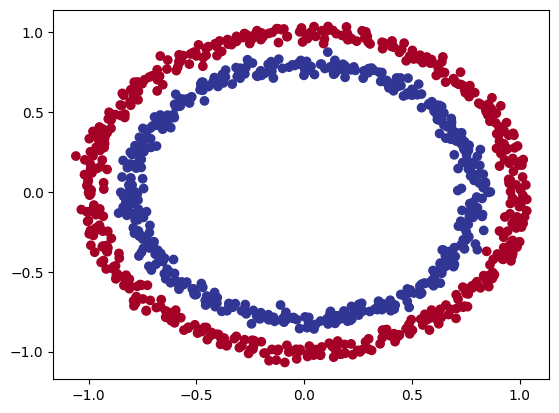

In [7]:
#Visualize with a plot
import matplotlib.pyplot as plt
plt.scatter(x= X[:,0],
            y = X[:,1],
            c = y,
            cmap = plt.cm.RdYlBu);


In [8]:
X.shape, y.shape

((1000, 2), (1000,))

## Turning data into tensors and spliting the data

In [9]:
import torch

In [10]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.2,
                                                    random_state=42)

In [12]:
len(X_train),len(y_train), len(X_test), len(y_test)

(800, 800, 200, 200)

# Building a model

In [13]:
import torch
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [14]:
# Construct a model class that subclasses nn.Module

class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()

    # Create 2 nn.Linear layers capable of handling X and y input and output shapes

    self.layer_1 = nn.Linear(in_features= 2, out_features= 5) # this takes in 2 features and produces 5 more detailed features for next layer
    self.layer_2 = nn.Linear(in_features=5, out_features=1) # recombines those 5 features and give the 1 output feature

  # Define a forward method containing the forward pass computation
  def forward(self, x):
    return self.layer_2(self.layer_1(x))


model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [15]:
# There's also another way of making layers using nn.Sequential

model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [16]:
# Make predictions with the model
untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, shape: {untrained_preds.shape}")
print(f"\nLength of test sample: {len(y_test)}, Shape: {y_test.shape}")
print(f"\nFirst 10 predictions: \n{untrained_preds[:10]}")
print(f"\nFirst 10 test labels: \n{y_test[:10]}")

Length of predictions: 200, shape: torch.Size([200, 1])

Length of test sample: 200, Shape: torch.Size([200])

First 10 predictions: 
tensor([[ 0.2143],
        [ 0.0710],
        [ 0.3042],
        [ 0.1900],
        [-0.1496],
        [-0.2335],
        [-0.2775],
        [-0.3499],
        [ 0.3232],
        [ 0.0563]], device='cuda:0', grad_fn=<SliceBackward0>)

First 10 test labels: 
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


## Setup loss function and optimizer

In [17]:
# Create a loss function
# loss_fn = nn.BCELoss() # BCELoss = no sigmoid built-in

loss_fn = nn.BCEWithLogitsLoss() # Sigmoid function built in

# Create an optimizer
optimizer = torch.optim.SGD(params = model_0.parameters(),
                            lr = 0.1)


In [18]:
# Calculate accuracy (a evaluation metric)

def accuracy_fn (y_true, y_pred):
  correct = torch.eq(y_true,y_pred).sum().item()
  acc = (correct / len(y_pred)) * 100

  return acc



###Training the model
 At first Going from raw model outputs to predicted labels (logits -> prediction probabilities -> prediction labels)

In [19]:
y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[ 0.2143],
        [ 0.0710],
        [ 0.3042],
        [ 0.1900],
        [-0.1496]], device='cuda:0', grad_fn=<SliceBackward0>)

In [20]:
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.5534],
        [0.5177],
        [0.5755],
        [0.5474],
        [0.4627]], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [21]:
# Predicted labels
y_preds = torch.round(y_pred_probs)
y_preds

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [0.]], device='cuda:0', grad_fn=<RoundBackward0>)

In [22]:
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))
y_preds.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


tensor([1., 1., 1., 1., 0.], device='cuda:0', grad_fn=<SqueezeBackward0>)

In [23]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

## Building a training and testing loop


In [24]:
torch.manual_seed(42)

# Set the number of epochs
epochs = 100

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
    ### Training
    model_0.train()

    # 1. Forward pass (model outputs raw logits)
    y_logits = model_0(X_train).squeeze() # squeeze to remove extra `1` dimensions, this won't work unless model and data are on same device
    y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labls

    # 2. Calculate loss/accuracy
    # loss = loss_fn(torch.sigmoid(y_logits), # Using nn.BCELoss you need torch.sigmoid()
    #                y_train)
    loss = loss_fn(y_logits, # Using nn.BCEWithLogitsLoss works with raw logits
                   y_train)
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_0.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Caculate loss/accuracy
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)

    # Print out what's happening every 10 epochs
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.70214, Accuracy: 50.25% | Test loss: 0.69757, Test acc: 51.00%
Epoch: 10 | Loss: 0.70013, Accuracy: 50.00% | Test loss: 0.69607, Test acc: 50.50%
Epoch: 20 | Loss: 0.69865, Accuracy: 49.88% | Test loss: 0.69504, Test acc: 49.50%
Epoch: 30 | Loss: 0.69754, Accuracy: 50.00% | Test loss: 0.69432, Test acc: 49.50%
Epoch: 40 | Loss: 0.69668, Accuracy: 50.25% | Test loss: 0.69381, Test acc: 49.50%
Epoch: 50 | Loss: 0.69600, Accuracy: 50.25% | Test loss: 0.69346, Test acc: 49.50%
Epoch: 60 | Loss: 0.69546, Accuracy: 50.12% | Test loss: 0.69322, Test acc: 49.50%
Epoch: 70 | Loss: 0.69503, Accuracy: 50.38% | Test loss: 0.69307, Test acc: 49.50%
Epoch: 80 | Loss: 0.69468, Accuracy: 50.12% | Test loss: 0.69297, Test acc: 49.00%
Epoch: 90 | Loss: 0.69440, Accuracy: 50.50% | Test loss: 0.69292, Test acc: 49.00%


In [25]:
import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
  print("helper_function.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary


In [26]:
# check out this for the imported functions: https://github.com/mrdbourke/pytorch-deep-learning/blob/main/helper_functions.py

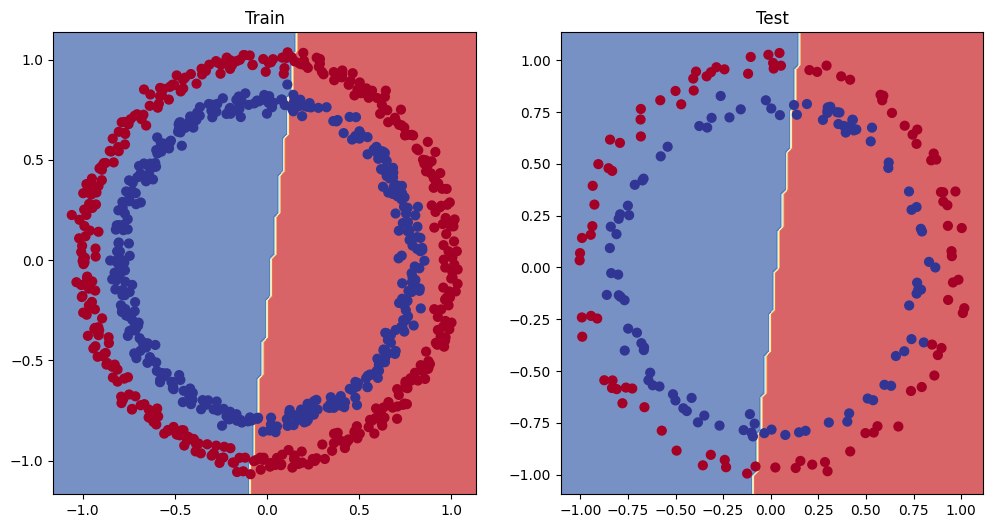

In [27]:
plt.figure(figsize =(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)


Here, we wanted to classify red circles and blue circles, but our model is using a slight stright line to make partition between them. Thus we need to make a model which can make non-linear partition between the data.

#Let's start off fresh

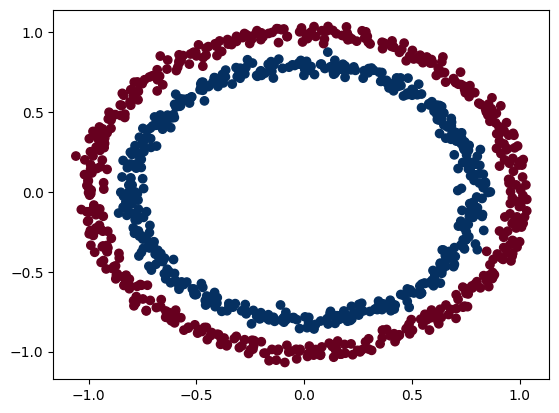

In [28]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples = 1000, noise=0.03, random_state=42)

plt.scatter(X[:,0],X[:,1], c = y, cmap=plt.cm.RdBu)

In [37]:
import torch
from sklearn.model_selection import train_test_split

X= torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train[:5], y_train[:5]


(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

In [38]:
from torch import nn
class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2,out_features=10)
    self.layer_2 = nn.Linear(in_features=10,out_features=10)
    self.layer_3 = nn.Linear(in_features=10,out_features=1)
    self.relu = nn.ReLU()

  def forward(self,x):
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))


model_3 = CircleModelV2().to(device)
print(model_3)

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)


In [39]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(),lr = 0.1)


In [40]:
torch.manual_seed(42)
epochs = 1000;

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  y_logits = model_3(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true=y_train,
                    y_pred = y_pred)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  model_3.eval()

  with torch.inference_mode():
    test_logits = model_3(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred = test_pred)

  if epoch%100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}")


Epoch: 0 | Loss: 0.69295, Accuracy: 50.00% | Test Loss: 0.69319, Test Accuracy: 50.00
Epoch: 100 | Loss: 0.69115, Accuracy: 52.88% | Test Loss: 0.69102, Test Accuracy: 52.50
Epoch: 200 | Loss: 0.68977, Accuracy: 53.37% | Test Loss: 0.68940, Test Accuracy: 55.00
Epoch: 300 | Loss: 0.68795, Accuracy: 53.00% | Test Loss: 0.68723, Test Accuracy: 56.00
Epoch: 400 | Loss: 0.68517, Accuracy: 52.75% | Test Loss: 0.68411, Test Accuracy: 56.50
Epoch: 500 | Loss: 0.68102, Accuracy: 52.75% | Test Loss: 0.67941, Test Accuracy: 56.50
Epoch: 600 | Loss: 0.67515, Accuracy: 54.50% | Test Loss: 0.67285, Test Accuracy: 56.00
Epoch: 700 | Loss: 0.66659, Accuracy: 58.38% | Test Loss: 0.66322, Test Accuracy: 59.00
Epoch: 800 | Loss: 0.65160, Accuracy: 64.00% | Test Loss: 0.64757, Test Accuracy: 67.50
Epoch: 900 | Loss: 0.62362, Accuracy: 74.00% | Test Loss: 0.62145, Test Accuracy: 79.00


In [41]:
model_3.eval()
with torch.inference_mode():
  y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()

y_preds[:10],y[:10]

(tensor([1., 0., 1., 0., 0., 1., 0., 0., 1., 0.], device='cuda:0'),
 tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 0.]))

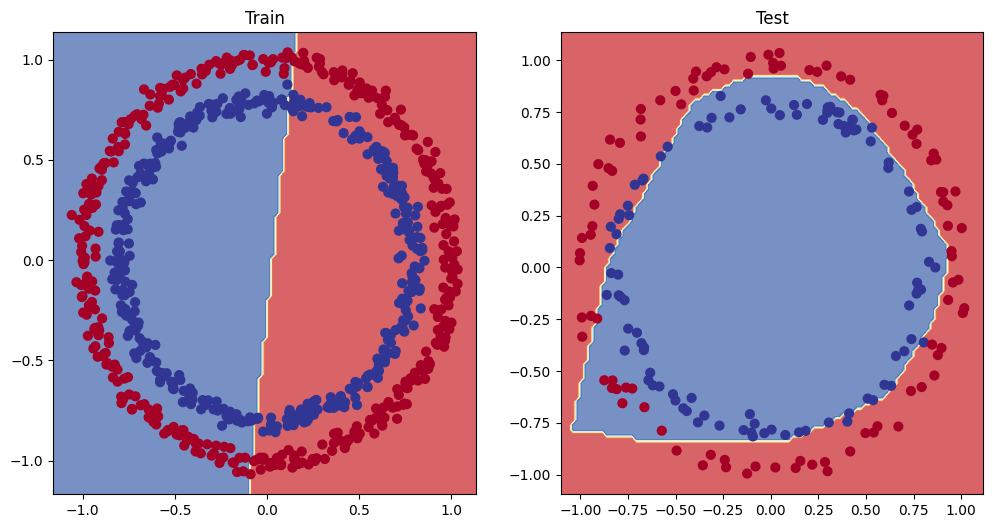

In [42]:
plt.figure(figsize= (12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0,X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test)

##Replicating non-linear activation functions

In [43]:
A = torch.arange(-10, 10, 1, dtype=torch.float32)
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

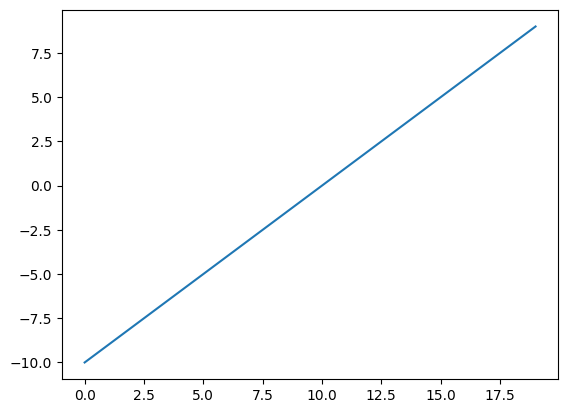

In [44]:
plt.plot(A)

The ReLU function turns all negatives to 0 and leaves the positive values as they are.

In [45]:
# creating our own ReLU fn

def relu(x):
  return torch.maximum(torch.tensor(0),x)

relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

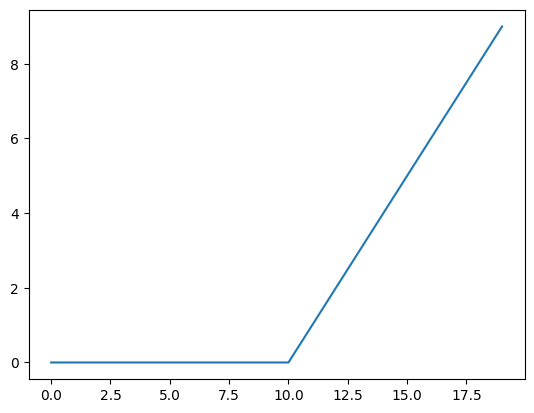

In [46]:
plt.plot(relu(A))

In [47]:
# creating a custom sigmoid function
def sigmoid(x):
  return 1/ (1+ torch.exp(-x))

sigmoid(A)

tensor([4.5398e-05, 1.2339e-04, 3.3535e-04, 9.1105e-04, 2.4726e-03, 6.6929e-03,
        1.7986e-02, 4.7426e-02, 1.1920e-01, 2.6894e-01, 5.0000e-01, 7.3106e-01,
        8.8080e-01, 9.5257e-01, 9.8201e-01, 9.9331e-01, 9.9753e-01, 9.9909e-01,
        9.9966e-01, 9.9988e-01])

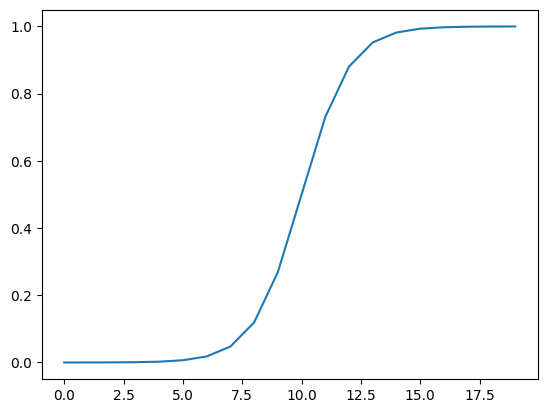

In [48]:
plt.plot(sigmoid(A))

#Putting up all together making a multi-class PyTorch Model


To make a multi-class classification, we create multiclass data using Scikit-Learn make_blobs() method

tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815]]) tensor([3, 2, 2, 1, 1])


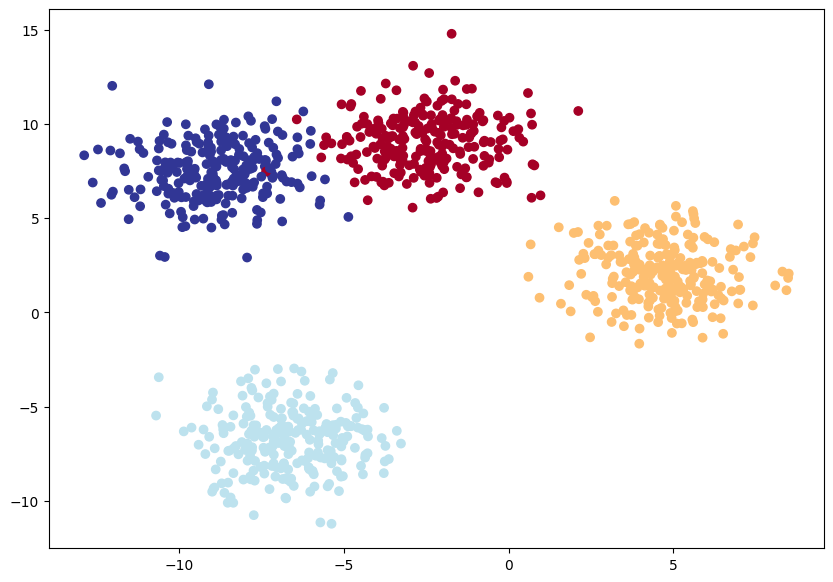

In [49]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

X_blob, y_blob = make_blobs(n_samples = 1000,
                           n_features = NUM_FEATURES,
                           centers = NUM_CLASSES,
                           cluster_std = 1.5,
                           random_state= RANDOM_SEED
                           )

X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
print(X_blob[:5],y_blob[:5])

X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                        y_blob,
                                                                        test_size=0.2,
                                                                        random_state=RANDOM_SEED)
plt.figure(figsize=(10,7))
plt.scatter(X_blob[:, 0],X_blob[:,1], c=y_blob, cmap = plt.cm.RdYlBu)


In [50]:
device

'cuda'

input_features (int): Number of input features to the model.
            <br>out_features (int): Number of output features of the model
              (how many classes there are).
           <br> hidden_units (int): Number of hidden units between layers, default 8.

In [51]:
from torch import nn

class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features= input_features, out_features=hidden_units),
        nn.Linear(in_features=hidden_units, out_features = hidden_units),
        nn.Linear(in_features=hidden_units, out_features=output_features)
    )
  def forward(self, x):
    return self.linear_layer_stack(x)

model_4 = BlobModel(input_features= NUM_FEATURES,
                    output_features=NUM_CLASSES,
                    hidden_units=8).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [52]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_4.parameters(), lr = 0.1)


In [53]:
model_4(X_blob_train.to(device))[:5]

tensor([[-1.2711, -0.6494, -1.4740, -0.7044],
        [ 0.2210, -1.5439,  0.0420,  1.1531],
        [ 2.8698,  0.9143,  3.3169,  1.4027],
        [ 1.9576,  0.3125,  2.2244,  1.1324],
        [ 0.5458, -1.2381,  0.4441,  1.1804]], device='cuda:0',
       grad_fn=<SliceBackward0>)

In [54]:
model_4(X_blob_train.to(device))[0].shape, NUM_CLASSES

(torch.Size([4]), 4)

Currently our model is giving out logits but we want label for the samples,
thus we use softmax activation function

In [56]:
y_logits = model_4(X_blob_test.to(device))

y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-1.2549, -0.8112, -1.4795, -0.5696],
        [ 1.7168, -1.2270,  1.7367,  2.1010],
        [ 2.2400,  0.7714,  2.6020,  1.0107],
        [-0.7993, -0.3723, -0.9138, -0.5388],
        [-0.4332, -1.6117, -0.6891,  0.6852]], device='cuda:0',
       grad_fn=<SliceBackward0>)
tensor([[0.1872, 0.2918, 0.1495, 0.3715],
        [0.2824, 0.0149, 0.2881, 0.4147],
        [0.3380, 0.0778, 0.4854, 0.0989],
        [0.2118, 0.3246, 0.1889, 0.2748],
        [0.1945, 0.0598, 0.1506, 0.5951]], device='cuda:0',
       grad_fn=<SliceBackward0>)


In [57]:
torch.sum(y_pred_probs[0])

tensor(1., device='cuda:0', grad_fn=<SumBackward0>)

In [58]:
print(y_pred_probs[0])
print(torch.argmax(y_pred_probs[0]))

tensor([0.1872, 0.2918, 0.1495, 0.3715], device='cuda:0',
       grad_fn=<SelectBackward0>)
tensor(3, device='cuda:0')


In [60]:
torch.manual_seed(42)

epochs = 100

X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device),  y_blob_test.to(device)

for epoch in range(epochs):
  model_4.train()

  y_logits = model_4(X_blob_train)
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

  loss = loss_fn(y_logits, y_blob_train)
  acc= accuracy_fn(y_true=y_blob_train,
                   y_pred=y_pred)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  model_4.eval()
  with torch.inference_mode():
    test_logits = model_4(X_blob_test)
    test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)

    test_loss = loss_fn(test_logits, y_blob_test)
    test_acc = accuracy_fn(y_true = y_blob_test,
                           y_pred = test_pred)

  if epoch%10 ==0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc:{acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 1.04324, Acc:65.50% | Test Loss: 0.57861, Test Accuracy: 95.50%
Epoch: 10 | Loss: 0.14398, Acc:99.12% | Test Loss: 0.13037, Test Accuracy: 99.00%
Epoch: 20 | Loss: 0.08062, Acc:99.12% | Test Loss: 0.07216, Test Accuracy: 99.50%
Epoch: 30 | Loss: 0.05924, Acc:99.12% | Test Loss: 0.05133, Test Accuracy: 99.50%
Epoch: 40 | Loss: 0.04892, Acc:99.00% | Test Loss: 0.04098, Test Accuracy: 99.50%
Epoch: 50 | Loss: 0.04295, Acc:99.00% | Test Loss: 0.03486, Test Accuracy: 99.50%
Epoch: 60 | Loss: 0.03910, Acc:99.00% | Test Loss: 0.03083, Test Accuracy: 99.50%
Epoch: 70 | Loss: 0.03643, Acc:99.00% | Test Loss: 0.02799, Test Accuracy: 99.50%
Epoch: 80 | Loss: 0.03448, Acc:99.00% | Test Loss: 0.02587, Test Accuracy: 99.50%
Epoch: 90 | Loss: 0.03300, Acc:99.12% | Test Loss: 0.02423, Test Accuracy: 99.50%


In [61]:
model_4.eval()
with torch.inference_mode():
  y_logits = model_4(X_blob_test)

y_logits[:10]

tensor([[  4.3377,  10.3539, -14.8948,  -9.7642],
        [  5.0142, -12.0371,   3.3860,  10.6699],
        [ -5.5885, -13.3448,  20.9894,  12.7711],
        [  1.8400,   7.5599,  -8.6016,  -6.9942],
        [  8.0726,   3.2906, -14.5998,  -3.6186],
        [  5.5844, -14.9521,   5.0168,  13.2890],
        [ -5.9739, -10.1913,  18.8655,   9.9179],
        [  7.0755,  -0.7601,  -9.5531,   0.1736],
        [ -5.5918, -18.5990,  25.5309,  17.5799],
        [  7.3142,   0.7197, -11.2017,  -1.2011]], device='cuda:0')

In [62]:
y_pred_probs = torch.softmax(y_logits, dim=1)

y_preds = y_pred_probs.argmax(dim=1)

print(f"Predictions: {y_preds[:10]}\nLabels: {y_blob_test[:10]}")
print(f"Test Accuracy: {accuracy_fn(y_true= y_blob_test, y_pred=y_preds)}%")

Predictions: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')
Labels: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')
Test Accuracy: 99.5%


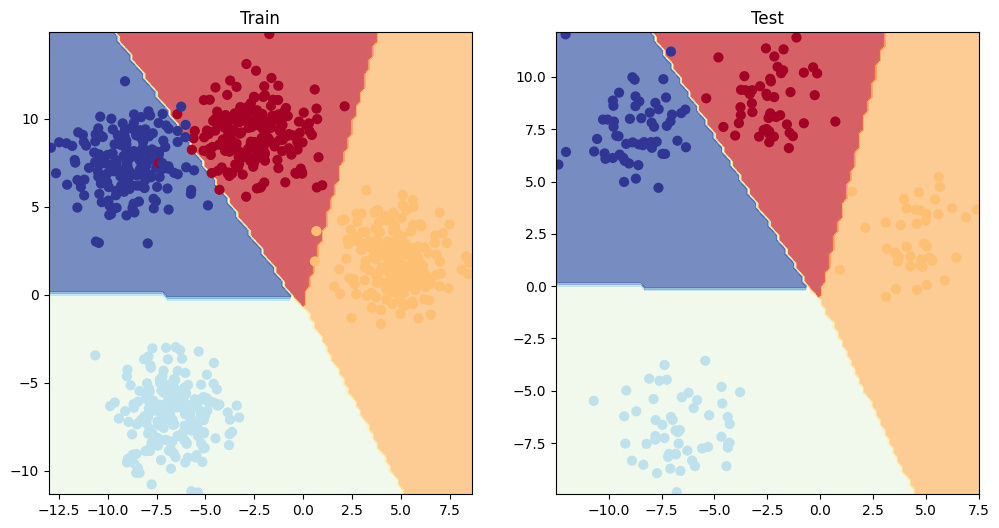

In [65]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_4,X_blob_train, y_blob_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)



Trying out torch metrics for evaluation

In [67]:
try:
  from torchmetrics import Accuracy
except:
  !pip install torchmetrics==0.9.3
  from torchmetrics import Accuracy

torchmetrics_accuracy = Accuracy(task = 'multiclass',num_classes = 4).to(device)

torchmetrics_accuracy(y_preds, y_blob_test)

tensor(0.9950, device='cuda:0')